# ResNet 和 MLP 训练速度的对比

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

## MLP

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(28*28, 64)
        self.l2 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.1)
        self.l3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        dropout = self.dropout(h2)
        logits = self.l3(dropout)
        return logits

## ResNet

In [3]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(28*28, 64)
        self.l2 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.1)
        self.l3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        dropout = self.dropout(h1 + h2)
        logits = self.l3(dropout)
        return logits

## Train loop

In [4]:
train_dataset = MNIST(
    root=".",
    train=True,
    download=True,
    transform=ToTensor()
)
val_dataset = MNIST(
    root=".",
    train=False,
    download=True,
    transform=ToTensor()
)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)

In [11]:
def train(model: nn.Module):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), 1e-2)
    epochs = 20
    val_loss_list = []
    val_acc_list = []
    for t in range(epochs):
        loss_list = []
        model.train()
        for X, y in train_dataloader:
            X, y = X.to("cuda:0"), y.to("cuda:0")
            pred = model(X)
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
        train_loss = torch.tensor(loss_list).mean()
        
        
        loss_list = []
        acc_list = []
        model.eval()
        with torch.no_grad():
            for X, y in val_dataloader:
                X, y = X.to("cuda:0"), y.to("cuda:0")
                pred = model(X)
                loss = loss_fn(pred, y)
                loss_list.append(loss.item())
                acc_list.extend((F.softmax(pred, dim=1).argmax(1) == y).cpu().tolist())
        
        val_loss = torch.tensor(loss_list).mean()
        val_acc = torch.tensor(acc_list, dtype=torch.float).mean()
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        print(f"Epoch {t+1:2}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")
    return val_loss_list, val_acc_list

In [12]:
mlp = MLP().to("cuda:0")
mlp_loss, mlp_acc = train(mlp)

Epoch  1: train_loss=1.8012 val_loss=0.8852 val_acc=0.7955
Epoch  2: train_loss=0.6491 val_loss=0.4407 val_acc=0.8821
Epoch  3: train_loss=0.4488 val_loss=0.3561 val_acc=0.8995
Epoch  4: train_loss=0.3887 val_loss=0.3256 val_acc=0.9064
Epoch  5: train_loss=0.3547 val_loss=0.2989 val_acc=0.9127
Epoch  6: train_loss=0.3317 val_loss=0.2807 val_acc=0.9178
Epoch  7: train_loss=0.3109 val_loss=0.2666 val_acc=0.9256
Epoch  8: train_loss=0.2946 val_loss=0.2517 val_acc=0.9283
Epoch  9: train_loss=0.2772 val_loss=0.2396 val_acc=0.9293
Epoch 10: train_loss=0.2644 val_loss=0.2294 val_acc=0.9345
Epoch 11: train_loss=0.2519 val_loss=0.2174 val_acc=0.9381
Epoch 12: train_loss=0.2389 val_loss=0.2082 val_acc=0.9383
Epoch 13: train_loss=0.2279 val_loss=0.1971 val_acc=0.9428
Epoch 14: train_loss=0.2185 val_loss=0.1908 val_acc=0.9454
Epoch 15: train_loss=0.2079 val_loss=0.1835 val_acc=0.9466
Epoch 16: train_loss=0.2020 val_loss=0.1783 val_acc=0.9470
Epoch 17: train_loss=0.1945 val_loss=0.1710 val_acc=0.95

In [13]:
resnet = ResNet().to("cuda:0")
resnet_loss, resnet_acc = train(resnet)

Epoch  1: train_loss=1.1728 val_loss=0.4988 val_acc=0.8763
Epoch  2: train_loss=0.4716 val_loss=0.3598 val_acc=0.9013
Epoch  3: train_loss=0.3871 val_loss=0.3143 val_acc=0.9124
Epoch  4: train_loss=0.3441 val_loss=0.2845 val_acc=0.9223
Epoch  5: train_loss=0.3139 val_loss=0.2632 val_acc=0.9238
Epoch  6: train_loss=0.2904 val_loss=0.2465 val_acc=0.9287
Epoch  7: train_loss=0.2683 val_loss=0.2283 val_acc=0.9349
Epoch  8: train_loss=0.2529 val_loss=0.2151 val_acc=0.9375
Epoch  9: train_loss=0.2365 val_loss=0.2039 val_acc=0.9402
Epoch 10: train_loss=0.2230 val_loss=0.1928 val_acc=0.9435
Epoch 11: train_loss=0.2106 val_loss=0.1807 val_acc=0.9481
Epoch 12: train_loss=0.2009 val_loss=0.1736 val_acc=0.9491
Epoch 13: train_loss=0.1926 val_loss=0.1664 val_acc=0.9523
Epoch 14: train_loss=0.1838 val_loss=0.1599 val_acc=0.9532
Epoch 15: train_loss=0.1744 val_loss=0.1532 val_acc=0.9548
Epoch 16: train_loss=0.1674 val_loss=0.1477 val_acc=0.9561
Epoch 17: train_loss=0.1613 val_loss=0.1426 val_acc=0.95

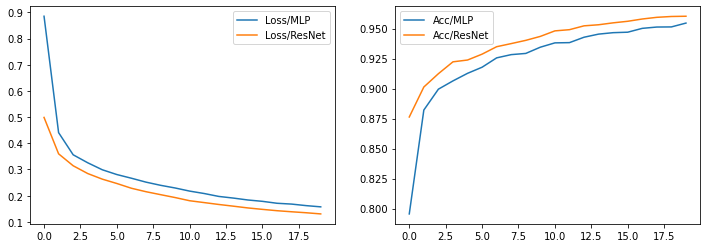

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mlp_loss, label="Loss/MLP")
plt.plot(resnet_loss, label="Loss/ResNet")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mlp_acc, label="Acc/MLP")
plt.plot(resnet_acc, label="Acc/ResNet")
plt.legend()

plt.show()